In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import warnings
import re
import string
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# EDA

In [2]:
df_original_data = pd.read_csv('Hotel_Reviews.csv')
df_all_data = df_original_data.copy()

In [3]:
df_all_data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


### Feature Engineering

In [4]:
def get_contries():
    df_all_data['Country'] = df_all_data.Hotel_Address.apply(lambda x: str(x).split(" ")[-1])
    df_all_data['Country'] = df_all_data['Country'].str.replace('Kingdom','United Kingdom')
get_contries()

In [5]:
df_all_data['Country'].unique()

array(['Netherlands', 'United Kingdom', 'France', 'Spain', 'Italy',
       'Austria'], dtype=object)

In [6]:
df_all_data['Country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: Country, dtype: int64

In [7]:
df_pos = df_all_data[['Positive_Review','Hotel_Name','Country','Reviewer_Score','Reviewer_Nationality']]
df_neg = df_all_data[['Negative_Review','Hotel_Name','Country','Reviewer_Score','Reviewer_Nationality']]
df_recom = df_all_data[['Reviewer_Nationality','Hotel_Name','Reviewer_Score']]

In [8]:
df_pos.rename(columns = {'Positive_Review':'Review'},inplace= True)
df_neg.rename(columns = {'Negative_Review':'Review'},inplace= True)

In [9]:
df_pos['Sentiment'] = 1
df_neg['Sentiment'] = 0
df_all = pd.concat([df_pos,df_neg],ignore_index=True)
df_drop = df_all.drop_duplicates()

In [10]:
df_drop = df_drop[df_drop['Review'].map(lambda x: x.isascii())]

### Data Cleaning

In [11]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
repeated_chars = lambda x: re.sub('(.)\\1{2,}', '\\1', x)
df_drop['Review'] = df_drop.Review.map(alphanumeric).map(punc_lower).map(repeated_chars)
df_drop

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
0,only the park outside of the hotel was beauti...,Hotel Arena,Netherlands,2.9,Russia,1
1,no real complaints the hotel was great great ...,Hotel Arena,Netherlands,7.5,Ireland,1
2,location was good and staff were ok it is cut...,Hotel Arena,Netherlands,7.1,Australia,1
3,great location in nice surroundings the bar a...,Hotel Arena,Netherlands,3.8,United Kingdom,1
4,amazing location and building romantic setting,Hotel Arena,Netherlands,6.7,New Zealand,1
...,...,...,...,...,...,...
1031471,no trolly or staff to help you take the lugga...,Atlantis Hotel Vienna,Austria,7.0,Kuwait,0
1031472,the hotel looks like but surely not,Atlantis Hotel Vienna,Austria,5.8,Estonia,0
1031473,the ac was useless it was a hot week in vienn...,Atlantis Hotel Vienna,Austria,2.5,Egypt,0
1031474,no negative,Atlantis Hotel Vienna,Austria,8.8,Mexico,0


In [12]:
data_sample = df_drop.sample(50000,random_state=2021)

In [14]:
from autocorrect import Speller
spell = Speller(lang='en')
data_sample['Review'] = data_sample['Review'].apply(lambda x: spell(x))

## Pickling

In [15]:
import pickle
filehandler = open("df50000.pickle","wb")
pickle.dump(data_sample,filehandler)
filehandler.close()

In [16]:
file = open('df50000.pickle', 'rb')
data_sample = pickle.load(file)
file.close()

In [17]:
df_drop

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
0,only the park outside of the hotel was beauti...,Hotel Arena,Netherlands,2.9,Russia,1
1,no real complaints the hotel was great great ...,Hotel Arena,Netherlands,7.5,Ireland,1
2,location was good and staff were ok it is cut...,Hotel Arena,Netherlands,7.1,Australia,1
3,great location in nice surroundings the bar a...,Hotel Arena,Netherlands,3.8,United Kingdom,1
4,amazing location and building romantic setting,Hotel Arena,Netherlands,6.7,New Zealand,1
...,...,...,...,...,...,...
1031471,no trolly or staff to help you take the lugga...,Atlantis Hotel Vienna,Austria,7.0,Kuwait,0
1031472,the hotel looks like but surely not,Atlantis Hotel Vienna,Austria,5.8,Estonia,0
1031473,the ac was useless it was a hot week in vienn...,Atlantis Hotel Vienna,Austria,2.5,Egypt,0
1031474,no negative,Atlantis Hotel Vienna,Austria,8.8,Mexico,0


In [18]:
data_sample

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
198260,friendly staff good service overall clean rooms,Radisson Blu Edwardian New Providence Wharf,United Kingdom,9.6,United Kingdom,1
378853,no positive,Leonardo Hotel Vienna,Austria,8.3,Romania,1
602911,very iverpriced,First Hotel Paris Tour Eiffel,France,5.0,Australia,0
746579,room was very dated and cramped not exactly r...,Radisson Blu Edwardian Vanderbilt,United Kingdom,9.6,United Kingdom,0
939234,no sauna,Golden Tulip Amsterdam Riverside,Netherlands,7.9,United Kingdom,0
...,...,...,...,...,...,...
500917,near by subway and near dance river,Park Inn by Radisson Uno City Vienna,Austria,8.8,Taiwan,1
482427,i like the lounge area furniture and open bri...,Novotel Milano Linate Aeroporto,Italy,6.7,Germany,1
135131,the location is central and easy to access he...,Novotel London Paddington,United Kingdom,7.1,New Zealand,1
719929,not enough info about parking when booking on...,Sanderson A Morgans Hotel,United Kingdom,7.5,United Kingdom,0


## Tokenization and Lemmatization

In [19]:
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data_sample['text_lemmatized'] = data_sample.Review.apply(lemmatize_text)

In [20]:
data_sample['Joined_text_lemmatize'] =  data_sample['text_lemmatized'].apply(lambda x: ' '.join(x))

### SpaCy

In [21]:
import spacy
spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
nlp = spacy.load('en_core_web_sm')
data_sample['spacy_doc'] = list(nlp.pipe(data_sample.Joined_text_lemmatize))
data_sample

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment,text_lemmatized,Joined_text_lemmatize,spacy_doc
198260,friendly staff good service overall clean rooms,Radisson Blu Edwardian New Providence Wharf,United Kingdom,9.6,United Kingdom,1,"[friendly, staff, good, service, overall, clea...",friendly staff good service overall clean room,"(friendly, staff, good, service, overall, clea..."
378853,no positive,Leonardo Hotel Vienna,Austria,8.3,Romania,1,"[no, positive]",no positive,"(no, positive)"
602911,very iverpriced,First Hotel Paris Tour Eiffel,France,5.0,Australia,0,"[very, iverpriced]",very iverpriced,"(very, iverpriced)"
746579,room was very dated and cramped not exactly r...,Radisson Blu Edwardian Vanderbilt,United Kingdom,9.6,United Kingdom,0,"[room, wa, very, dated, and, cramped, not, exa...",room wa very dated and cramped not exactly rom...,"(room, wa, very, dated, and, cramped, not, exa..."
939234,no sauna,Golden Tulip Amsterdam Riverside,Netherlands,7.9,United Kingdom,0,"[no, sauna]",no sauna,"(no, sauna)"
...,...,...,...,...,...,...,...,...,...
500917,near by subway and near dance river,Park Inn by Radisson Uno City Vienna,Austria,8.8,Taiwan,1,"[near, by, subway, and, near, dance, river]",near by subway and near dance river,"(near, by, subway, and, near, dance, river)"
482427,i like the lounge area furniture and open bri...,Novotel Milano Linate Aeroporto,Italy,6.7,Germany,1,"[i, like, the, lounge, area, furniture, and, o...",i like the lounge area furniture and open brig...,"(i, like, the, lounge, area, furniture, and, o..."
135131,the location is central and easy to access he...,Novotel London Paddington,United Kingdom,7.1,New Zealand,1,"[the, location, is, central, and, easy, to, ac...",the location is central and easy to access hea...,"(the, location, is, central, and, easy, to, ac..."
719929,not enough info about parking when booking on...,Sanderson A Morgans Hotel,United Kingdom,7.5,United Kingdom,0,"[not, enough, info, about, parking, when, book...",not enough info about parking when booking on ...,"(not, enough, info, about, parking, when, book..."


#### Spliting Reviews and making a new sentiment column

In [23]:
filehandler = open("wordPo","wb")
pickle.dump(df_pos,filehandler)
filehandler.close()
filehandler = open("wordNeg","wb")
pickle.dump(df_neg,filehandler)
filehandler.close()


Positive = open('wordPo', 'rb')
Negative = open('wordNeg', 'rb')
wordss = pickle.load(Positive)
words_neg = pickle.load(Negative)
Positive.close()
Negative.close()

In [24]:
positive_reviews = data_sample[data_sample.Sentiment==1]
negative_reviews = data_sample[data_sample.Sentiment==0]

In [25]:
sam_pos_df = positive_reviews.copy()
sam_neg_df = negative_reviews.copy()

In [26]:
sam_pos_df['Review'] = sam_pos_df['Review'].str.replace("hotel" , "")
sam_neg_df['Review'] = sam_neg_df['Review'].str.replace("hotel" , "")

## WordCloud for Positive Words

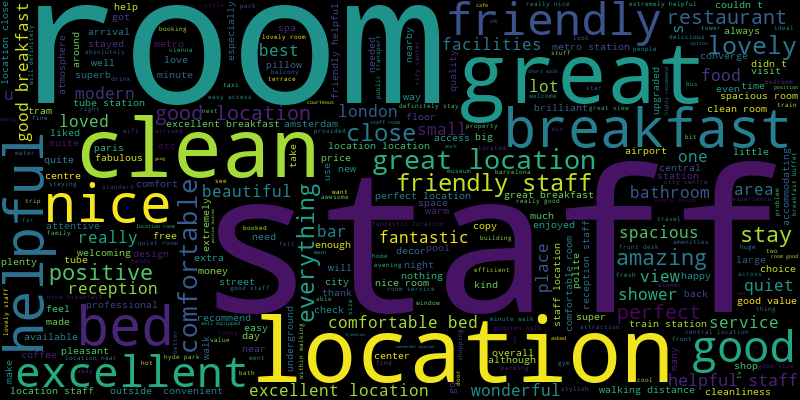

In [27]:
from wordcloud import WordCloud

long_string = ','.join(list(sam_pos_df['Review'].values))
wordcloud = WordCloud(background_color="black", max_words=300, contour_width=2, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

## WordCloud for Negative Words

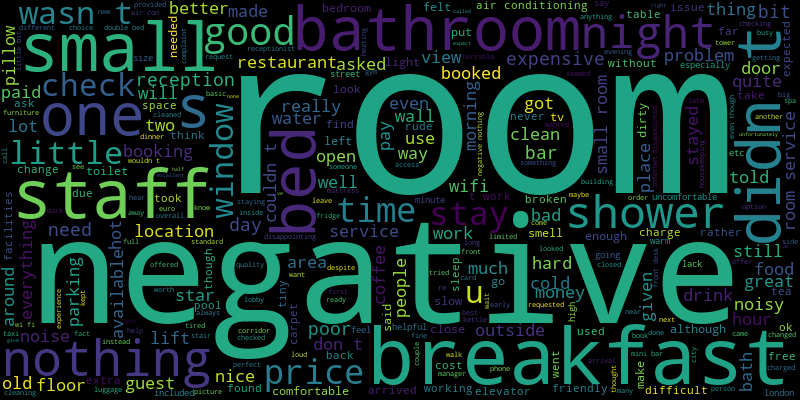

In [28]:
long_string = ','.join(list(sam_neg_df['Review'].values))
wordcloud = WordCloud(background_color="black", max_words=300, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

### Adjective and Noun Counter

In [29]:
from collections import Counter,Counter,defaultdict

In [30]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_ =='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_ == 'NOUN']

In [31]:
print('Positive Adjective:',Counter(pos_adj).most_common(3))
print('Negative Adjective:',Counter(neg_adj).most_common(3))
print('Positive Noun:',Counter(pos_noun).most_common(3))
print('Negative Noun:',Counter(neg_noun).most_common(3))

Positive Adjective: [('good', 5872), ('great', 5655), ('friendly', 4811)]
Negative Adjective: [('negative', 3168), ('small', 2680), ('little', 1156)]
Positive Noun: [('staff', 10595), ('location', 10445), ('room', 9680)]
Negative Noun: [('room', 10978), ('hotel', 4230), ('breakfast', 3054)]


## Removing English Stopwords using NLTK

In [32]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
from sklearn.feature_extraction import text
ENGLISH_STOP_WORDS = stopwords.words('english')
stop_words = text.ENGLISH_STOP_WORDS.union(['didnt','did','havent', 'week', 'hi','wa','ha','day','today','really','also',
                                            'go', 'us', 'dont', 'got', 'im', 'ive','burger','food' ,'came', 'back',
                                           'get','try', 'would', 'time','good','great','service','didn','definitely','hotel','went','took','left',
                                            'check','told','asked','like','don','wasn','hotels','just','don','said','people','ve','stay','stayed',
                                           'loved','com','night','birthday','free','touch','little','given','making','hear','recommend','card','make',
                                           'feel','days','differ','thier','couldn','breakfast'])

In [34]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = CountVectorizer(stop_words=stop_words)
tfidvectorizer = TfidfVectorizer(stop_words=stop_words)
doc_word = vectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])
doc_word_tfid = tfidvectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])
doc_word.shape

(26930, 7534)

In [35]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [36]:
example = positive_reviews['Joined_text_lemmatize']

# Topicing

## NMF

In [37]:
from sklearn.decomposition import PCA,TruncatedSVD,NMF

In [38]:
nmf_model = NMF(4, random_state=7)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic_tfid = nmf_model.fit_transform(doc_word_tfid)

In [39]:
display_topics(nmf_model, vectorizer.get_feature_names(), 20)


Topic  0
location, excellent, perfect, staff, central, fantastic, facility, convenient, comfort, value, station, cleanliness, nice, close, price, near, amazing, ideal, best, tube

Topic  1
positive, think, attitude, ended, relocating, helpful, nice, excellent, actually, cleanliness, reception, point, experience, doomed, regina, classy, porter, busicuts, environment, brittania

Topic  2
staff, friendly, helpful, excellent, lovely, reception, extremely, amazing, polite, nice, welcoming, pleasant, restaurant, fantastic, bar, attentive, perfect, professional, super, facility

Topic  3
room, comfortable, clean, bed, nice, excellent, lovely, spacious, quiet, bathroom, modern, view, size, big, shower, station, close, large, facility, perfect


In [40]:
display_topics(nmf_model, tfidvectorizer.get_feature_names(), 20)


Topic  0
location, excellent, perfect, staff, central, fantastic, facility, convenient, comfort, value, station, cleanliness, nice, close, price, near, amazing, ideal, best, tube

Topic  1
positive, think, attitude, ended, relocating, helpful, nice, excellent, actually, cleanliness, reception, point, experience, doomed, regina, classy, porter, busicuts, environment, brittania

Topic  2
staff, friendly, helpful, excellent, lovely, reception, extremely, amazing, polite, nice, welcoming, pleasant, restaurant, fantastic, bar, attentive, perfect, professional, super, facility

Topic  3
room, comfortable, clean, bed, nice, excellent, lovely, spacious, quiet, bathroom, modern, view, size, big, shower, station, close, large, facility, perfect


In [41]:
# Based on CountVectorizer
Vt = pd.DataFrame(doc_topic.round(5),
             index = example,
             columns = ["Staff","Room",'Location','Transportation'])
Vt

,Staff,Room,Location,Transportation
Joined_text_lemmatize,,,,
friendly staff good service overall clean room,0.10329,0.10793,0.00000,0.00763
no positive,0.00008,0.00008,0.00000,0.00000
the design are beautiful staff are friendly atmosphere is comfortable good location,0.10167,0.00000,0.09791,0.03926
the bed wa super pillow were fab great night s sleep,0.00045,0.00000,0.00000,0.06025
everything wa perfect,0.00085,0.00251,0.00811,0.00044
...,...,...,...,...
location just off oxford street minute walk for tube bus and trip plenty of cafe restaurant around the location,0.00000,0.00000,0.21706,0.03599
the staff,0.06827,0.00000,0.00000,0.00000
near by subway and near dance river,0.00000,0.00000,0.00667,0.01028


## LSA

In [42]:
from scipy.linalg import svd
lsa = TruncatedSVD(4)
doc_topic = lsa.fit_transform(doc_word)
doc_topic_tfid = lsa.fit_transform(doc_word_tfid)
lsa.explained_variance_ratio_

array([0.04568826, 0.04952865, 0.03490487, 0.02343597])

In [43]:
display_topics(lsa, vectorizer.get_feature_names(),20)


Topic  0
location, staff, friendly, room, helpful, excellent, clean, nice, comfortable, bed, perfect, lovely, fantastic, quiet, facility, amazing, view, close, station, central

Topic  1
positive, staff, helpful, nice, excellent, room, friendly, reception, think, attitude, ended, relocating, cleanliness, actually, clean, point, experience, doomed, bathroom, regina

Topic  2
staff, friendly, helpful, room, clean, comfortable, bed, nice, excellent, lovely, spacious, quiet, amazing, reception, extremely, view, bathroom, modern, facility, bar

Topic  3
room, bed, comfortable, clean, nice, spacious, quiet, bathroom, lovely, size, modern, excellent, big, view, shower, large, station, close, small, facility


In [44]:
display_topics(lsa, tfidvectorizer.get_feature_names(), 20)


Topic  0
location, staff, friendly, room, helpful, excellent, clean, nice, comfortable, bed, perfect, lovely, fantastic, quiet, facility, amazing, view, close, station, central

Topic  1
positive, staff, helpful, nice, excellent, room, friendly, reception, think, attitude, ended, relocating, cleanliness, actually, clean, point, experience, doomed, bathroom, regina

Topic  2
staff, friendly, helpful, room, clean, comfortable, bed, nice, excellent, lovely, spacious, quiet, amazing, reception, extremely, view, bathroom, modern, facility, bar

Topic  3
room, bed, comfortable, clean, nice, spacious, quiet, bathroom, lovely, size, modern, excellent, big, view, shower, large, station, close, small, facility


## CorEx

In [45]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

### Positive Reviews

In [46]:
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=2000,
                            stop_words=stop_words,token_pattern='\\b[a-z][a-z]+\\b',
                            binary=True)
doc_word = vectorizer.fit_transform(positive_reviews['Review'])
words = list(np.asarray(vectorizer.get_feature_names()))

In [47]:
topic_model = ct.Corex(n_hidden=4, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=negative_reviews)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: station,close,walk,metro,walking,tube,restaurants,distance,near,walking distance
1: staff,friendly,helpful,staff friendly,friendly staff,friendly helpful,staff helpful,helpful staff,positive,location staff
2: bar,coffee,water,tea,view,floor,amazing,complimentary,upgraded,pool
3: room,comfortable,clean,bed,rooms,spacious,bathroom,nice,quiet,size


### Negative Reviews

In [48]:
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=2000,
                            stop_words=stop_words,token_pattern='\\b[a-z][a-z]+\\b',
                            binary=True)
doc_word = vectorizer.fit_transform(negative_reviews['Review'])
words = list(np.asarray(vectorizer.get_feature_names()))

In [49]:
topic_model = ct.Corex(n_hidden=4, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=negative_reviews)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: room,negative,small,bathroom,shower,room small,air,bed,window,floor
1: staff,reception,rude,bar,arrived,helpful,desk,wait,friendly,mini bar
2: coffee,tea,booked,double,money,paid,pay,booking,tea coffee,extra
3: rooms,noise,old,morning,need,tv,poor,building,tired,area


# Classification

## Models

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve,confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier

In [51]:
def get_scores(model,X_train,X_val):
    model.fit(X_train,y_train)
    print(f'Training Score:{model.score(X_train,y_train)}')
    print(f'Precision score:{precision_score(y_val,model.predict(X_val))}')
    print(f'Recall score:{recall_score(y_val,model.predict(X_val))}')
    print(f'Validation score:{model.score(X_val,y_val)}')
    print(f"F1 score:{f1_score(model.predict(X_val),y_val)}")
    print(f'Accuracy score:{accuracy_score(y_val, model.predict(X_val))}')

In [52]:
X = data_sample.Review
y = data_sample.Sentiment

In [53]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.8, random_state=42)

In [54]:
cv1 = CountVectorizer()
X_train_cv1 = cv1.fit_transform(X_train)
X_val_cv1  = cv1.transform(X_val)

### LR

In [55]:
lr = LogisticRegression()
get_scores(lr,X_train_cv1,X_val_cv1)

Training Score:0.966
Precision score:0.9324418604651162
Recall score:0.9306022977834513
Validation score:0.9263125
F1 score:0.931521170935703
Accuracy score:0.9263125


### TF–IDF

In [56]:
tfidf1 = TfidfVectorizer()
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_val_tfidf1  = tfidf1.transform(X_val)
get_scores(lr,X_train_tfidf1,X_val_tfidf1)

Training Score:0.950375
Precision score:0.9482047912061653
Recall score:0.9209701752350006
Validation score:0.93034375
F1 score:0.9343890736761546
Accuracy score:0.93034375


### Decision Tree Classifier

In [57]:
dtc = DecisionTreeClassifier()
get_scores(dtc,X_train_cv1,X_val_cv1)

Training Score:0.994375
Precision score:0.8777624309392266
Recall score:0.8849947777648833
Validation score:0.8716875
F1 score:0.8813637676971974
Accuracy score:0.8716875


### Naive Bayes Classifier

In [58]:
BNB = BernoulliNB()
get_scores(BNB,X_train_tfidf1,X_val_tfidf1) 

Training Score:0.88975
Precision score:0.8382149269043344
Recall score:0.9481838226761053
Validation score:0.87353125
F1 score:0.8898145879277956
Accuracy score:0.87353125


## Final Results

In [59]:
model = LogisticRegression()
tfidf1 = TfidfVectorizer()
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val)
X_test_tfidf1  = tfidf1.transform(X_test)
model.fit(X_train_val_tfidf1 ,y_train_val)
print(f'Training score:{model.score(X_train_val_tfidf1,y_train_val)}')
print(f'Precision score:{precision_score(y_test,model.predict(X_test_tfidf1))}')
print(f'Recall score:{recall_score(y_test,model.predict(X_test_tfidf1))}')
print(f'Validation score:{model.score(X_test_tfidf1,y_test)}')
print(f"F1 score:{f1_score(model.predict(X_test_tfidf1),y_test)}")
print(f'Accuracy score:{accuracy_score(y_test, model.predict(X_test_tfidf1))}')

Training score:0.9493
Precision score:0.9576012223071046
Recall score:0.9295513533555803
Validation score:0.9398
F1 score:0.9433678269049858
Accuracy score:0.9398
